In [43]:
# !pip install xgboost

In [55]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier




In [2]:
demographic_data=pd.DataFrame()
for file in os.listdir("./demo_data/"):
    tmp=pd.read_sas("./demo_data/"+file)
    demographic_data=pd.concat([demographic_data,tmp],ignore_index=True)

In [3]:
demographic_data.describe()

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,DMQMILIT,...,DMDHHSZE,DMDHRBR4,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,DMDYRUSZ,DMDMARTZ,WTINTPRP,WTMECPRP
count,65253.000000,65253.000000,65253.000000,61952.000000,65253.000000,6.525300e+04,1.369000e+04,9.855000e+03,65253.000000,6723.000000,...,3.915600e+04,28844.000000,9254.000000,8764.000000,9063.000000,4751.000000,3028.000000,9232.000000,15560.000000,1.556000e+04
mean,86883.683662,21.794446,1.949412,1.505714,1.505709,3.265830e+01,2.780704e+02,3.741461e+02,3.101727,1.886509,...,4.204975e-01,1.412668,2.860061,2.050776,1.472691,2.110714,6.701453,1.708622,20714.921079,2.071492e+04
std,21490.051071,24.767029,0.219156,0.499971,0.499971,2.497059e+01,2.892662e+02,2.805416e+02,1.261560,0.330086,...,7.164718e-01,2.808172,0.810059,0.652806,0.721168,0.688517,18.534338,2.755878,25323.916482,2.711491e+04
min,51624.000000,6.000000,1.000000,1.000000,1.000000,5.397605e-79,5.397605e-79,5.397605e-79,1.000000,1.000000,...,5.397605e-79,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1017.784203,5.397605e-79
25%,67937.000000,7.000000,2.000000,1.000000,1.000000,1.000000e+01,1.800000e+01,1.200000e+02,2.000000,2.000000,...,5.397605e-79,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,7435.543058,6.762822e+03
50%,85890.000000,9.000000,2.000000,2.000000,2.000000,2.800000e+01,1.650000e+02,3.260000e+02,3.000000,2.000000,...,5.397605e-79,1.000000,3.000000,2.000000,1.000000,2.000000,3.000000,1.000000,12712.564300,1.263958e+04
75%,102203.000000,10.000000,2.000000,2.000000,2.000000,5.400000e+01,5.100000e+02,6.090000e+02,4.000000,2.000000,...,1.000000e+00,2.000000,4.000000,2.000000,2.000000,3.000000,4.000000,2.000000,22761.140907,2.330839e+04
max,124822.000000,66.000000,2.000000,2.000000,2.000000,8.000000e+01,9.590000e+02,9.590000e+02,5.000000,9.000000,...,3.000000e+00,99.000000,4.000000,3.000000,3.000000,3.000000,99.000000,99.000000,338363.600192,3.675557e+05


In [4]:
data_dict={}
for dir in os.listdir("./"):
    df=pd.DataFrame()
    if dir.endswith(".ipynb") or dir=="phy_act_y" or dir=="occupation" or dir.endswith(".docx"):
        continue
    for file in os.listdir("./"+dir+"/"):
        if file.endswith(".XPT") and file.startswith("P_"):
            tmp=pd.read_sas("./"+dir+"/"+file)
            df=pd.concat([df,tmp])
    data_dict[dir]=df


In [5]:
data_dict.keys()

dict_keys(['bp_n_cholestrol', 'cig_use', 'demo_data', 'Diabetes', 'diet_behavior_nut', 'med_condition', 'phy_act', 'wt_hist'])

In [6]:
# Sequence number, gender, age in yrs, race/ethinicity, Country of birth, Ratio of family income to poverty, 
demo_data_cols=["SEQN","RIAGENDR","RIDAGEYR","RIDRETH1","DMDBORN4","INDFMPIR"]
#Sequence number, Ever told you had high blood pressure, Doctor told you - high cholesterol level
bp_n_cholestrol_cols=["SEQN","BPQ020","BPQ080"]
#Sequence number, Smoked at least 100 cigarettes in life
cig_use_cols=["SEQN","SMQ020"]
#Sequence number, Doctor told you have diabetes
Diabetes_cols=["SEQN","DIQ010"]
#Sequence number, How healthy is the diet, # of meals not home prepared During the past 7 days,
diet_behavior_nut_cols=["SEQN","DBQ700","DBD895"]
#Sequence number, Ever been told you have asthma, Taking treatment for anemia/past 3 mos, Doctor ever said you were overweight, Close relative had heart attack?, Close relative had diabetes?, Ever told had congestive heart failure, Ever told you had heart attack
med_condition_col=["SEQN","MCQ010","MCQ053","MCQ080","MCQ300A","MCQ300C","MCQ160B","MCQ160E"]
#Sequence number, Occupation group code: longest job
occupation_col=["SEQN","OCD390"]
#Sequence number, Vigorous work activity, Moderate recreational activities
phy_act_cols=["SEQN","PAQ605","PAQ665"]
#Sequence number, How do you consider your weight, Current self-reported weight (pounds), Self-reported weight - 1 yr ago (pounds)
wt_hist_cols=["SEQN","WHQ030","WHD020","WHD050"]


In [7]:
data_dict["bp_n_cholestrol"]=data_dict["bp_n_cholestrol"][bp_n_cholestrol_cols]
data_dict["demo_data"]=data_dict["demo_data"][demo_data_cols]
data_dict["cig_use"]=data_dict["cig_use"][cig_use_cols]
data_dict["Diabetes"]=data_dict["Diabetes"][Diabetes_cols]
data_dict["diet_behavior_nut"]=data_dict["diet_behavior_nut"][diet_behavior_nut_cols]
data_dict["med_condition"]=data_dict["med_condition"][med_condition_col]
# data_dict["occupation"]=data_dict["occupation"][occupation_col]
data_dict["phy_act"]=data_dict["phy_act"][phy_act_cols]
data_dict["wt_hist"]=data_dict["wt_hist"][wt_hist_cols]


In [8]:
merged_df=pd.DataFrame(columns=['SEQN'])
for k in data_dict.keys():
    merged_df=pd.merge(left=merged_df,right=data_dict[k],how="outer",right_on="SEQN",left_on="SEQN")

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15560 entries, 0 to 15559
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      15560 non-null  float64
 1   BPQ020    10195 non-null  float64
 2   BPQ080    10195 non-null  float64
 3   SMQ020    9693 non-null   float64
 4   RIAGENDR  15560 non-null  float64
 5   RIDAGEYR  15560 non-null  float64
 6   RIDRETH1  15560 non-null  float64
 7   DMDBORN4  15560 non-null  float64
 8   INDFMPIR  13359 non-null  float64
 9   DIQ010    14986 non-null  float64
 10  DBQ700    10195 non-null  float64
 11  DBD895    14865 non-null  float64
 12  MCQ010    14986 non-null  float64
 13  MCQ053    14986 non-null  float64
 14  MCQ080    10195 non-null  float64
 15  MCQ300A   9232 non-null   float64
 16  MCQ300C   9232 non-null   float64
 17  MCQ160B   9232 non-null   float64
 18  MCQ160E   9232 non-null   float64
 19  PAQ605    9693 non-null   float64
 20  PAQ665    9693 non-null   fl

In [10]:
merged_df["BPQ080"].value_counts()

2.0    6832
1.0    3295
9.0      66
7.0       2
Name: BPQ080, dtype: int64

In [11]:
#Ever told had congestive heart failure, Ever told you had heart attack, Doctor told you - high cholesterol level, Ever told you had high blood pressure
y_cols=["SEQN","MCQ160B","MCQ160E","BPQ080","BPQ020"]

In [12]:
X_cols=merged_df.columns.drop(y_cols).to_list()
X_cols.append("SEQN")

In [13]:
X_cols

['SMQ020',
 'RIAGENDR',
 'RIDAGEYR',
 'RIDRETH1',
 'DMDBORN4',
 'INDFMPIR',
 'DIQ010',
 'DBQ700',
 'DBD895',
 'MCQ010',
 'MCQ053',
 'MCQ080',
 'MCQ300A',
 'MCQ300C',
 'PAQ605',
 'PAQ665',
 'WHQ030',
 'WHD020',
 'WHD050',
 'SEQN']

In [14]:
X_data=merged_df[X_cols]
y_data=merged_df[y_cols]

In [15]:
y_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15560 entries, 0 to 15559
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     15560 non-null  float64
 1   MCQ160B  9232 non-null   float64
 2   MCQ160E  9232 non-null   float64
 3   BPQ080   10195 non-null  float64
 4   BPQ020   10195 non-null  float64
dtypes: float64(5)
memory usage: 729.4 KB


In [16]:
for col in y_cols:
    print(col)
    print(y_data[col].value_counts())
    print()

SEQN
109266.0    1
112290.0    1
112026.0    1
112035.0    1
112036.0    1
           ..
117191.0    1
117192.0    1
117193.0    1
117194.0    1
124820.0    1
Name: SEQN, Length: 15560, dtype: int64

MCQ160B
2.0    8848
1.0     361
9.0      23
Name: MCQ160B, dtype: int64

MCQ160E
2.0    8786
1.0     432
9.0      14
Name: MCQ160E, dtype: int64

BPQ080
2.0    6832
1.0    3295
9.0      66
7.0       2
Name: BPQ080, dtype: int64

BPQ020
2.0    6586
1.0    3597
9.0      12
Name: BPQ020, dtype: int64



In [17]:
y_data["aggregated_label"]=y_data[['MCQ160B',	"MCQ160E",	"BPQ080"	,"BPQ020"]].min(axis=1)

C:\Users\kjmak\AppData\Local\Temp\ipykernel_31224\1538087024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data["aggregated_label"]=y_data[['MCQ160B',	"MCQ160E",	"BPQ080"	,"BPQ020"]].min(axis=1)


In [18]:
y_data["aggregated_label"]=y_data["aggregated_label"].fillna(2)

C:\Users\kjmak\AppData\Local\Temp\ipykernel_31224\3569363204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data["aggregated_label"]=y_data["aggregated_label"].fillna(2)


In [19]:
y_data.head()

,SEQN,MCQ160B,MCQ160E,BPQ080,BPQ020,aggregated_label
0,109266.0,2.0,2.0,1.0,2.0,1.0
1,109267.0,2.0,2.0,2.0,2.0,2.0
2,109268.0,NaN,NaN,2.0,2.0,2.0
3,109271.0,2.0,2.0,1.0,2.0,1.0
4,109273.0,2.0,2.0,2.0,2.0,2.0


In [20]:
y_data["aggregated_label"].value_counts().index

Float64Index([2.0, 1.0], dtype='float64')

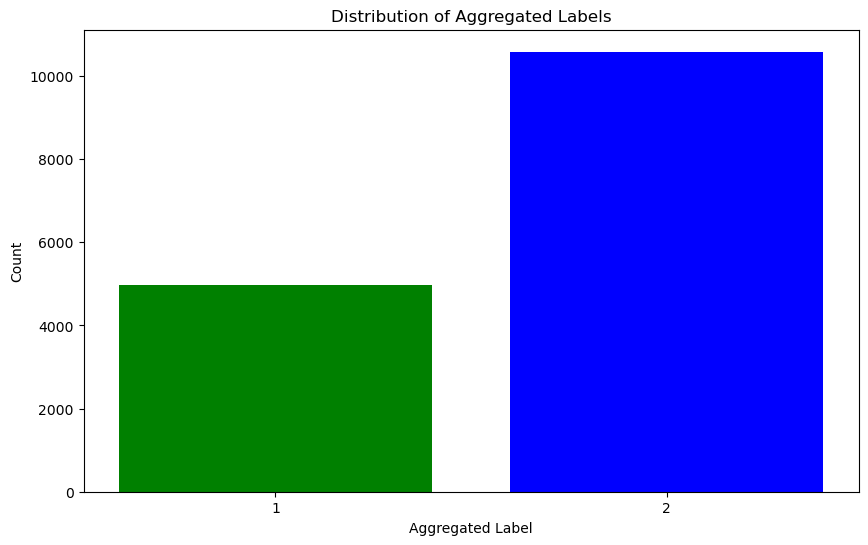

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(y_data["aggregated_label"].value_counts().index, y_data["aggregated_label"].value_counts().values, color=['blue', 'green'])

# Adding titles and labels
plt.title('Distribution of Aggregated Labels')
plt.xlabel('Aggregated Label')
plt.ylabel('Count')
plt.xticks(y_data["aggregated_label"].value_counts().index)

# Show plot
plt.show()

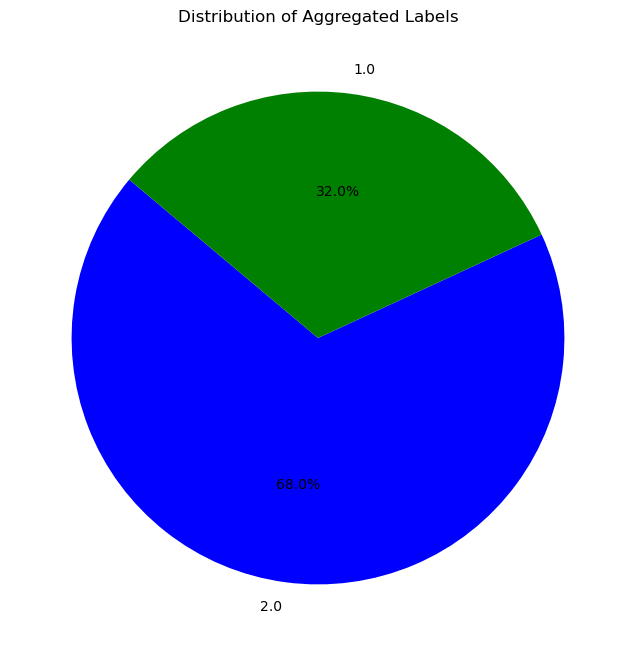

In [22]:
plt.figure(figsize=(8, 8))
plt.pie(y_data["aggregated_label"].value_counts().values, labels=y_data["aggregated_label"].value_counts().index, colors=['blue', 'green'], autopct='%1.1f%%', startangle=140)

# Adding a title
plt.title('Distribution of Aggregated Labels')

# Show plot
plt.show()

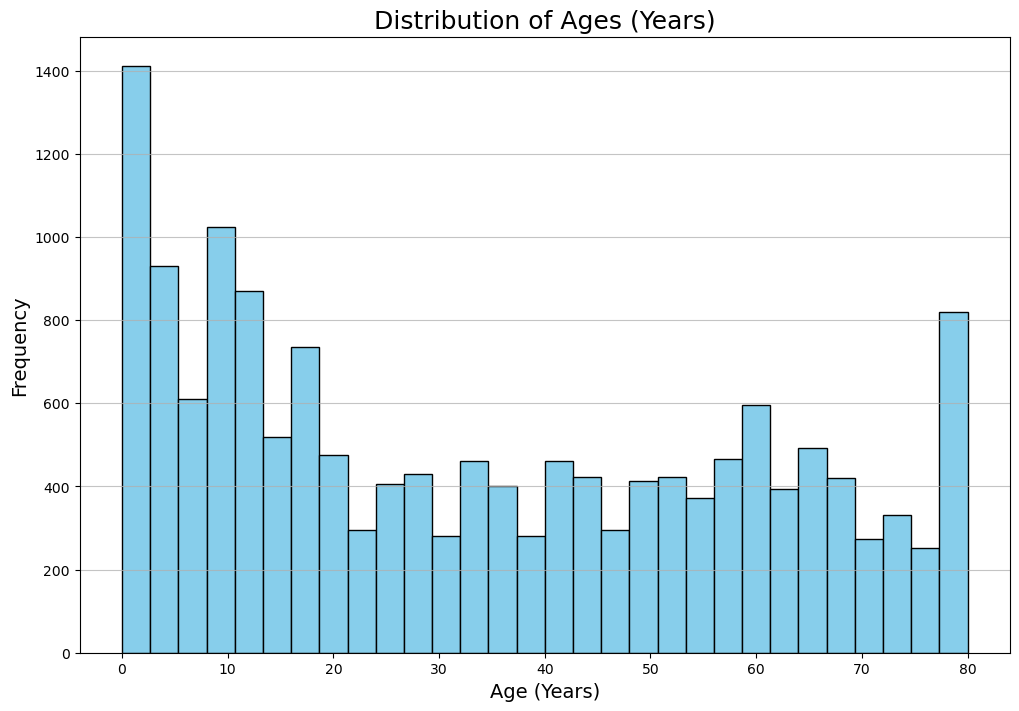

In [23]:
plt.figure(figsize=(12, 8))
plt.hist(X_data["RIDAGEYR"], bins=30, color='skyblue', edgecolor='black')

# Adding titles and labels for better presentation
plt.title('Distribution of Ages (Years)', fontsize=18)
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', alpha=0.75)

# Show the improved histogram
plt.show()

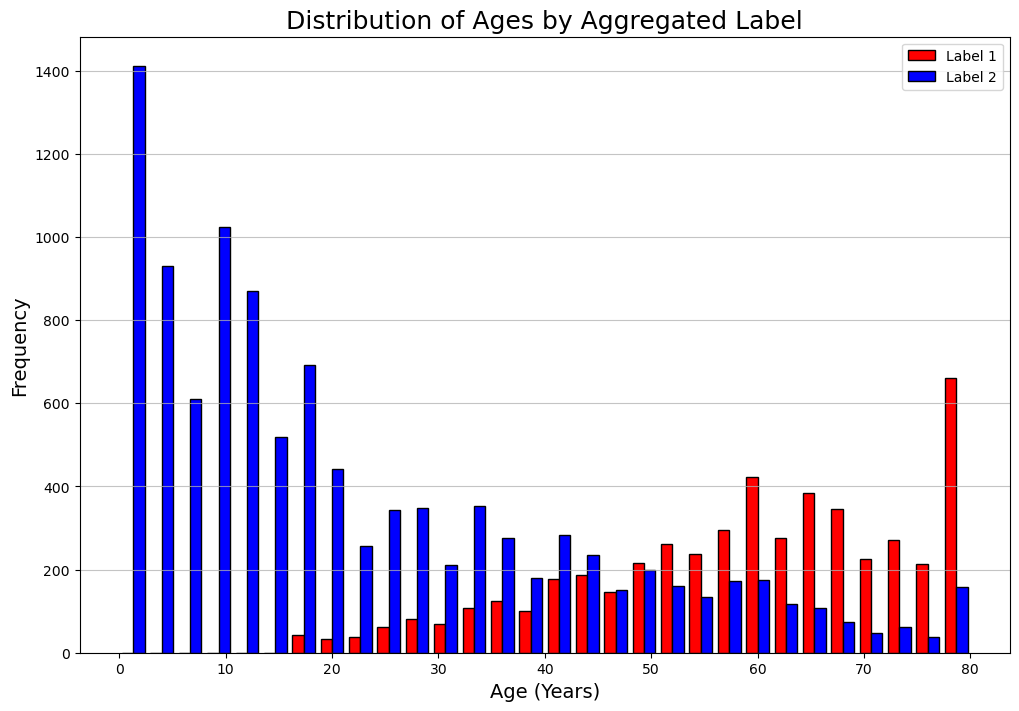

In [24]:
age_data_1=pd.merge(X_data[["SEQN","RIDAGEYR"]],y_data[y_data["aggregated_label"]==1][["SEQN","aggregated_label"]],left_on="SEQN",right_on="SEQN")["RIDAGEYR"]
age_data_2=pd.merge(X_data[["SEQN","RIDAGEYR"]],y_data[y_data["aggregated_label"]==2][["SEQN","aggregated_label"]],left_on="SEQN",right_on="SEQN")["RIDAGEYR"]

plt.figure(figsize=(12, 8))

plt.hist([age_data_1, age_data_2], bins=30, color=['red', 'blue'], edgecolor='black', label=['Label 1', 'Label 2'])

# Adding titles and labels

plt.title('Distribution of Ages by Aggregated Label', fontsize=18)
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.75)

In [25]:
X_data["weight_diff"]=X_data["WHD020"]-X_data["WHD050"]
weight_diff1=pd.merge(X_data[["SEQN","INDFMPIR"]],y_data[y_data["aggregated_label"]==1][["SEQN","aggregated_label"]],left_on="SEQN",right_on="SEQN")["INDFMPIR"]
weight_diff2=pd.merge(X_data[["SEQN","INDFMPIR"]],y_data[y_data["aggregated_label"]==2][["SEQN","aggregated_label"]],left_on="SEQN",right_on="SEQN")["INDFMPIR"]


C:\Users\kjmak\AppData\Local\Temp\ipykernel_31224\670836538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data["weight_diff"]=X_data["WHD020"]-X_data["WHD050"]


In [26]:
weight_diff1.dropna()

0       5.00
2       1.20
3       3.61
4       0.96
6       5.00
        ... 
4971    1.37
4973    1.93
4974    5.00
4975    2.19
4976    3.71
Name: INDFMPIR, Length: 4247, dtype: float64

In [27]:
X_data[X_data["WHD020"]<1000].WHD020.describe()

count    10010.000000
mean       180.219980
std         49.084205
min         67.000000
25%        145.000000
50%        172.000000
75%        205.000000
max        578.000000
Name: WHD020, dtype: float64

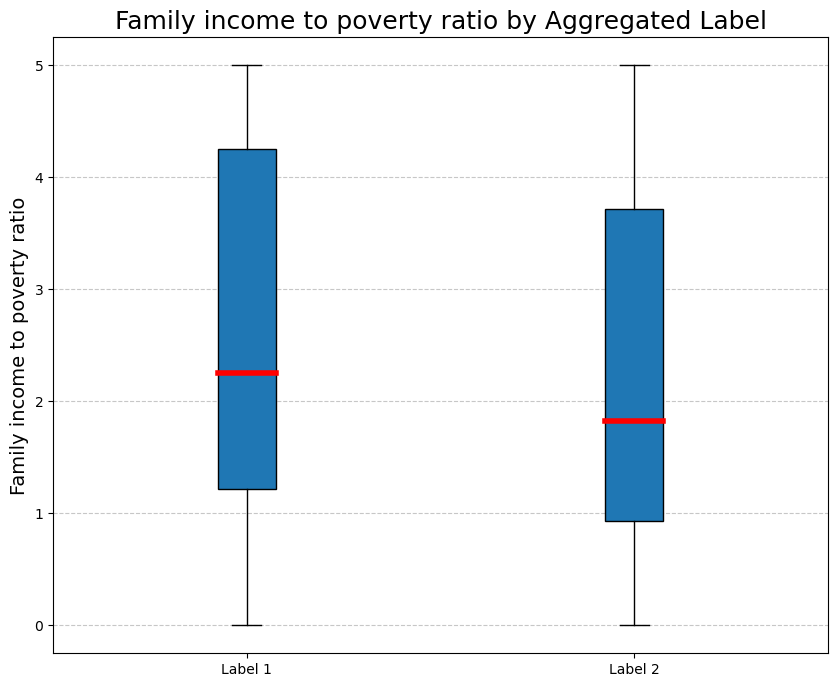

In [28]:
plt.figure(figsize=(10, 8))

# Combining the weight difference data into a list of arrays, one for each label
data_to_plot = [weight_diff1.dropna(), weight_diff2.dropna()]

# Creating boxplot
medianprops = dict(linestyle='-', linewidth=4, color='red')  
plt.boxplot(data_to_plot, patch_artist=True, labels=['Label 1', 'Label 2'],medianprops=medianprops)

# Adding titles and labels
plt.title('Family income to poverty ratio by Aggregated Label', fontsize=18)
plt.ylabel('Family income to poverty ratio', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [29]:
correlation_matrix_x = X_data.corr()

In [30]:
correlation_matrix_x

,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDBORN4,INDFMPIR,DIQ010,DBQ700,DBD895,MCQ010,...,MCQ080,MCQ300A,MCQ300C,PAQ605,PAQ665,WHQ030,WHD020,WHD050,SEQN,weight_diff
SMQ020,1.000000,0.168257,-0.165500,0.015496,0.058926,0.110418,0.051179,-0.071020,-0.001975,0.016828,...,0.020580,-0.000193,0.008775,0.084117,-0.068654,0.021713,0.011708,0.025754,-0.022214,-0.014617
RIAGENDR,0.168257,1.000000,0.014040,-0.003442,0.024950,-0.022912,0.019253,0.051587,-0.007119,-0.013539,...,-0.070796,-0.011590,-0.046647,0.161425,0.040955,-0.137703,0.020332,0.020530,-0.007435,-0.000899
RIDAGEYR,-0.165500,0.014040,1.000000,0.020238,0.053527,0.144037,-0.241385,-0.120492,-0.019174,0.006853,...,-0.064456,-0.019495,-0.015265,0.147302,0.106566,-0.064121,-0.028738,-0.017381,0.001663,-0.010569
RIDRETH1,0.015496,-0.003442,0.020238,1.000000,-0.026618,0.093275,0.003194,-0.128822,0.015606,-0.016393,...,0.070554,0.008150,0.021135,0.056769,-0.035115,0.060568,-0.080146,-0.049691,-0.003745,-0.028235
DMDBORN4,0.058926,0.024950,0.053527,-0.026618,1.000000,-0.007157,-0.005757,-0.012416,-0.000846,0.021829,...,0.029017,-0.000099,0.001114,0.021620,0.009877,0.017725,0.054658,0.053111,-0.001800,-0.000300
INDFMPIR,0.110418,-0.022912,0.144037,0.093275,-0.007157,1.000000,0.014648,-0.178240,-0.018052,0.039299,...,-0.029365,-0.018602,0.013149,0.046658,-0.192507,-0.058756,-0.065499,-0.075810,0.005826,0.011569
DIQ010,0.051179,0.019253,-0.241385,0.003194,-0.005757,0.014648,1.000000,-0.034122,-0.001160,0.052253,...,0.127052,0.002670,0.061063,-0.043685,-0.062824,0.080385,-0.006848,0.018117,0.006623,-0.025164
DBQ700,-0.071020,0.051587,-0.120492,-0.128822,-0.012416,-0.178240,-0.034122,1.000000,0.004267,-0.039177,...,-0.165624,0.019716,-0.031533,-0.067581,0.134169,-0.224336,0.039041,0.010948,0.021387,0.027243
DBD895,-0.001975,-0.007119,-0.019174,0.015606,-0.000846,-0.018052,-0.001160,0.004267,1.000000,-0.001275,...,0.031410,-0.006280,-0.005153,-0.007331,0.019906,0.039943,0.010159,0.026267,-0.009980,-0.016737
MCQ010,0.016828,-0.013539,0.006853,-0.016393,0.021829,0.039299,0.052253,-0.039177,-0.001275,1.000000,...,0.065846,-0.005525,0.048006,0.040624,0.004413,0.031382,0.014768,0.035522,0.009459,-0.021622


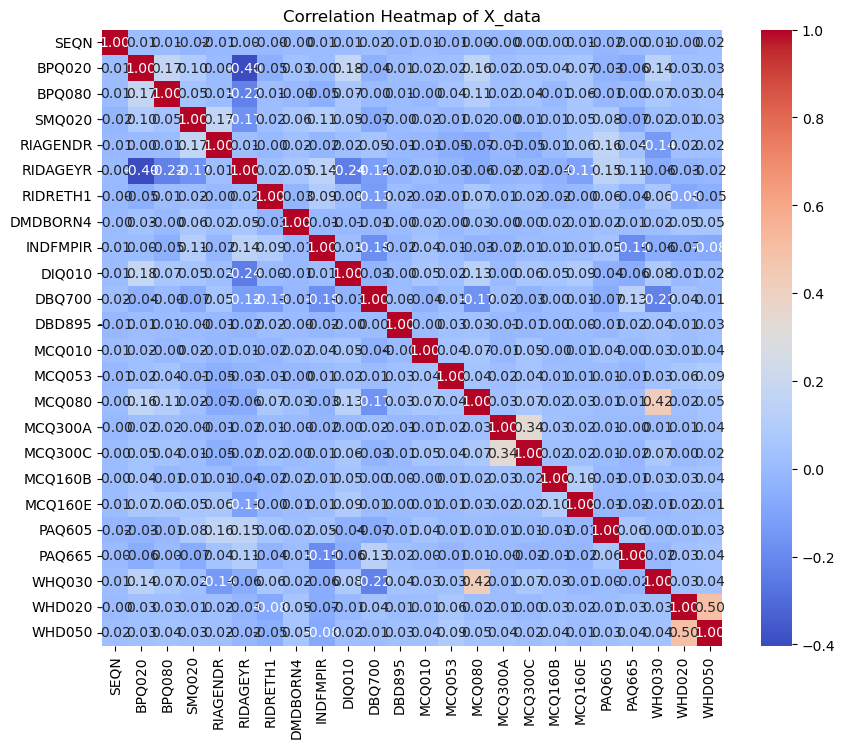

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of X_data')
plt.show()

In [32]:
X_data.columns

Index(['SMQ020', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN4', 'INDFMPIR',
       'DIQ010', 'DBQ700', 'DBD895', 'MCQ010', 'MCQ053', 'MCQ080', 'MCQ300A',
       'MCQ300C', 'PAQ605', 'PAQ665', 'WHQ030', 'WHD020', 'WHD050', 'SEQN',
       'weight_diff'],
      dtype='object')

In [33]:
y_data.columns

Index(['SEQN', 'MCQ160B', 'MCQ160E', 'BPQ080', 'BPQ020', 'aggregated_label'], dtype='object')

In [34]:
y_data.describe()

,SEQN,MCQ160B,MCQ160E,BPQ080,BPQ020,aggregated_label
count,15560.00000,9232.000000,9232.000000,10195.000000,10195.000000,15560.000000
mean,117042.50000,1.978336,1.963821,1.723100,1.655419,1.680077
std,4491.92943,0.400907,0.346128,0.754121,0.540174,0.466461
min,109263.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,113152.75000,2.000000,2.000000,1.000000,1.000000,1.000000
50%,117042.50000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,120932.25000,2.000000,2.000000,2.000000,2.000000,2.000000
max,124822.00000,9.000000,9.000000,9.000000,9.000000,2.000000


In [35]:
X_data.describe()

,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDBORN4,INDFMPIR,DIQ010,DBQ700,DBD895,MCQ010,...,MCQ080,MCQ300A,MCQ300C,PAQ605,PAQ665,WHQ030,WHD020,WHD050,SEQN,weight_diff
count,9693.000000,15560.000000,1.556000e+04,15560.000000,15560.000000,1.335900e+04,14986.000000,10195.000000,1.486500e+04,14986.000000,...,10195.000000,9232.000000,9232.000000,9693.00000,9693.000000,10195.000000,10195.000000,10195.000000,15560.00000,10195.000000
mean,1.601981,1.503792,3.374248e+01,3.249871,1.230206,2.405937e+00,1.926265,3.037764,2.690817e+01,1.852996,...,1.632075,2.035854,1.627383,1.75539,1.598679,1.969985,355.559686,368.111525,117042.50000,-12.551839
std,0.512981,0.500002,2.532053e+01,1.222644,1.728083,1.634346e+00,0.368923,1.037196,4.758291e+02,0.434663,...,0.566104,1.129812,1.017355,0.47176,0.501840,1.019181,1293.013129,1338.128630,4491.92943,1315.243833
min,1.000000,1.000000,5.397605e-79,1.000000,1.000000,5.397605e-79,1.000000,1.000000,5.397605e-79,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,67.000000,67.000000,109263.00000,-9906.000000
25%,1.000000,1.000000,1.000000e+01,3.000000,1.000000,1.020000e+00,2.000000,2.000000,1.000000e+00,2.000000,...,1.000000,2.000000,1.000000,2.00000,1.000000,1.000000,146.000000,145.000000,113152.75000,-7.000000
50%,2.000000,2.000000,3.000000e+01,3.000000,1.000000,1.960000e+00,2.000000,3.000000,2.000000e+00,2.000000,...,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,175.000000,175.000000,117042.50000,0.000000
75%,2.000000,2.000000,5.600000e+01,4.000000,1.000000,3.880000e+00,2.000000,4.000000,4.000000e+00,2.000000,...,2.000000,2.000000,2.000000,2.00000,2.000000,3.000000,210.000000,212.000000,120932.25000,7.000000
max,9.000000,2.000000,8.000000e+01,5.000000,99.000000,5.000000e+00,9.000000,9.000000,9.999000e+03,9.000000,...,9.000000,9.000000,9.000000,9.00000,9.000000,9.000000,9999.000000,9999.000000,124822.00000,9891.000000


In [36]:
X_data=X_data.set_index("SEQN")
y_data=y_data.set_index("SEQN")
target=y_data["aggregated_label"]
target=target.map({1:1,2:0})

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2, random_state=42)

In [52]:
def make_visuals(best_model, X_train_reduced,X_test_reduced):
    best_model.fit(X_train_reduced, y_train)
    y_pred = best_model.predict(X_test_reduced)


    fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test_reduced)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(classification_report(y_test, y_pred))

    

(12448, 20)
Index(['RIDAGEYR', 'WHD020', 'WHD050', 'MCQ300A', 'INDFMPIR', 'weight_diff',
       'DBD895', 'MCQ300C', 'MCQ080', 'PAQ605'],
      dtype='object')
[2, 17, 18, 12, 5, 19, 8, 13, 11, 14]
------------------Classification Report for Uniform Predictor (baseline)--------------------------------


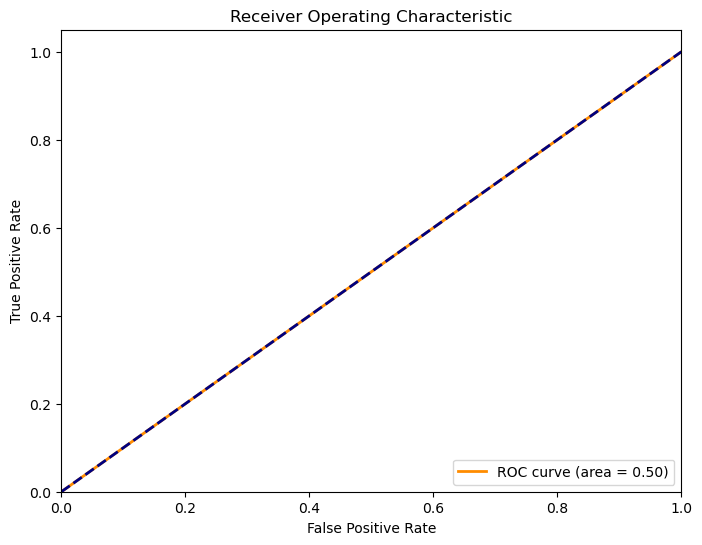

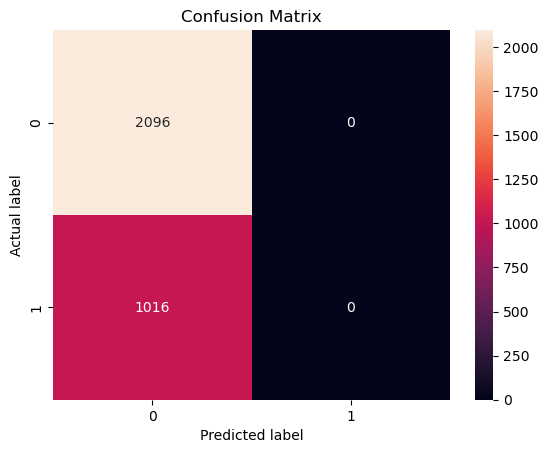

c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2096
           1       0.00      0.00      0.00      1016

    accuracy                           0.67      3112
   macro avg       0.34      0.50      0.40      3112
weighted avg       0.45      0.67      0.54      3112

Best parameters for XGBoost: {'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Test Accuracy for XGBoost: 0.8499357326478149
------------------Classification Report for XGBoost--------------------------------


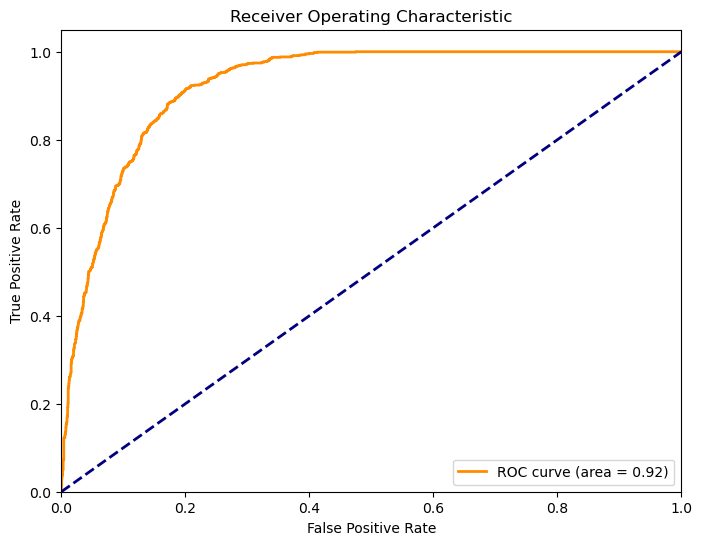

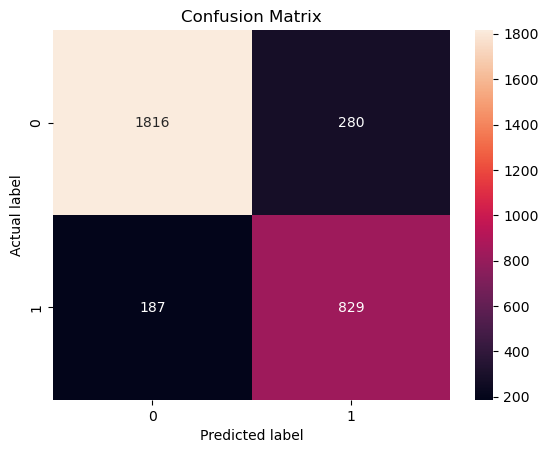

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2096
           1       0.75      0.82      0.78      1016

    accuracy                           0.85      3112
   macro avg       0.83      0.84      0.83      3112
weighted avg       0.85      0.85      0.85      3112



c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for LogisticRegression: {'classifier__C': 10}
Test Accuracy for LogisticRegression: 0.8383676092544987
------------------Classification Report for LogisticRegression--------------------------------


c:\Users\kjmak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


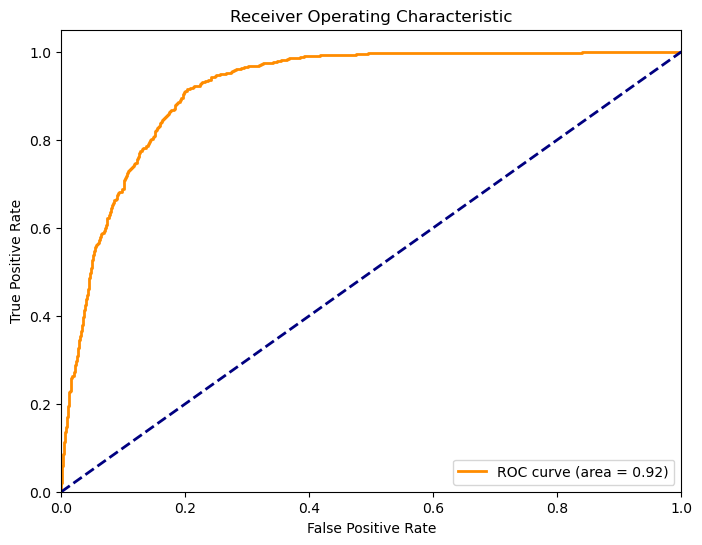

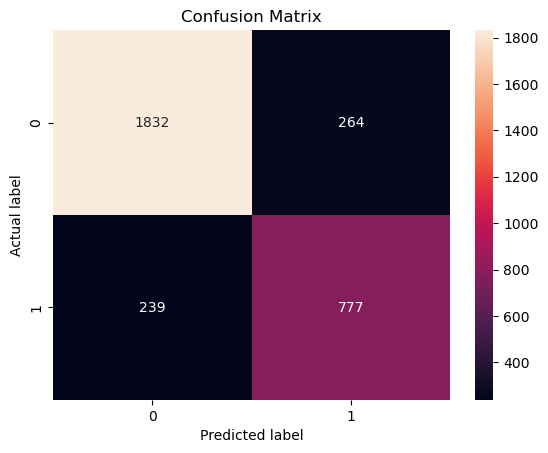

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2096
           1       0.75      0.76      0.76      1016

    accuracy                           0.84      3112
   macro avg       0.82      0.82      0.82      3112
weighted avg       0.84      0.84      0.84      3112

Best parameters for DecisionTreeClassifier: {'classifier__max_depth': 5}
Test Accuracy for DecisionTreeClassifier: 0.8386889460154242
------------------Classification Report for DecisionTreeClassifier--------------------------------


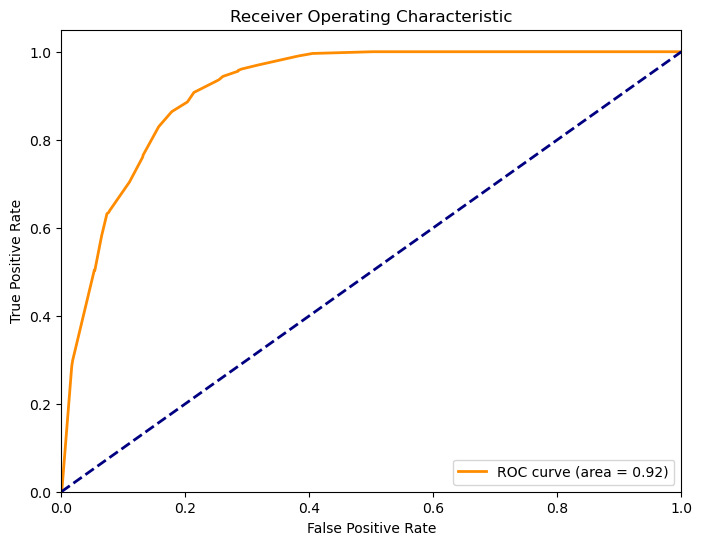

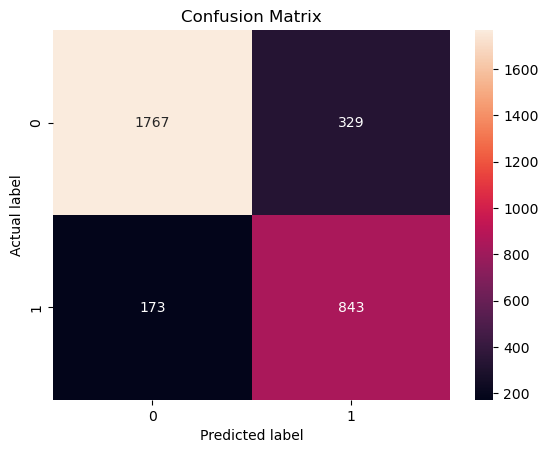

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2096
           1       0.72      0.83      0.77      1016

    accuracy                           0.84      3112
   macro avg       0.82      0.84      0.82      3112
weighted avg       0.85      0.84      0.84      3112



In [59]:
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
# X = X_train.drop('target', axis=1)
X_train = imputer.fit_transform(X_train)
X_test=imputer.transform(X_test)
# y = data['target']
print(X_train.shape)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and select the top 10
feature_importances = rf.feature_importances_
top_features_indices = list(np.argsort(feature_importances)[::-1][:10])
top_features = X_data.columns[top_features_indices]
print(top_features)
print(top_features_indices)
# print(X_train)

# Reduce training and test sets to top features
X_train_reduced = X_train[:, top_features_indices]
X_test_reduced = X_test[:, top_features_indices]

dummy_clf = DummyClassifier(strategy="most_frequent")
print(f"------------------Classification Report for Dummy Predictor (baseline)--------------------------------")
make_visuals(dummy_clf,X_train_reduced,X_test_reduced)


# Setup GridSearchCV with different classifiers
classifiers = {
    
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss'), 
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'SVC': SVC()
}

param_grid = {
    
    'XGBoost': {'classifier__max_depth': [3, 5, 7], 'classifier__n_estimators': [50, 100, 200]},
    'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
    'DecisionTreeClassifier': {'classifier__max_depth': [5, 10, 20]}
    # 'SVC': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}
}

# Perform grid search
for name, classifier in classifiers.items():
    pipe = Pipeline([('classifier', classifier)])
    search = GridSearchCV(pipe, param_grid[name], cv=5, scoring='accuracy')
    search.fit(X_train_reduced, y_train)
    print(f"Best parameters for {name}: {search.best_params_}")
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_reduced)
    print(f"Test Accuracy for {name}: {accuracy_score(y_test, y_pred)}")
    print(f"------------------Classification Report for {name}--------------------------------")
    make_visuals(best_model,X_train_reduced,X_test_reduced)

In [43]:
best_model=xgb.XGBClassifier(eval_metric='mlogloss',classifier__max_depth= 3, classifier__n_estimators= 50)
best_model.fit(X_train_reduced, y_train)
y_pred = best_model.predict(X_test_reduced)



c:\Users\kjmak\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [16:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "classifier__max_depth", "classifier__n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


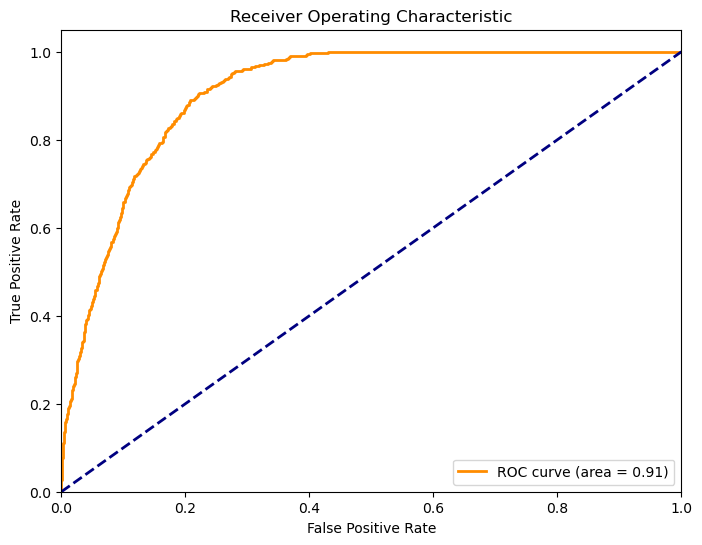

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test_reduced)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

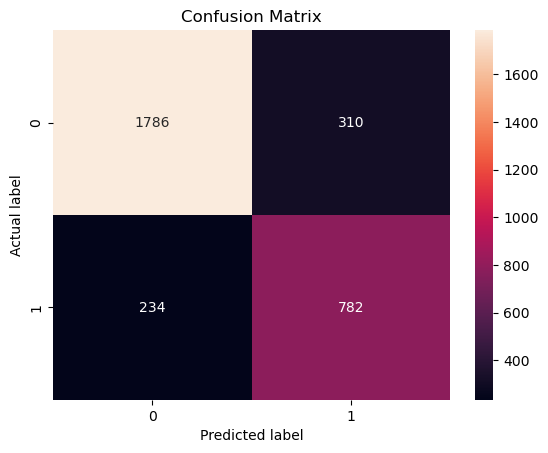

In [45]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      2096
           1       0.72      0.77      0.74      1016

    accuracy                           0.83      3112
   macro avg       0.80      0.81      0.80      3112
weighted avg       0.83      0.83      0.83      3112

